<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/Splitter_playground_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %tensorflow_version 1.x

In [2]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 165 (delta 78), reused 71 (delta 26), pack-reused 0
Receiving objects: 100% (165/165), 47.89 MiB | 9.62 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os
from tqdm import trange

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# adapted from Keith Ito's tacotron implementation
# https://github.com/keithito/tacotron/blob/master/util/audio.py

import librosa
import numpy as np


class Audio():
    def __init__(self):
        self.ref_level_db = 20.0
        self.n_fft = 1200
        self.hop_length = 160
        self.win_length = 400
        self.min_level_db = -100.0

    def wav2spec(self, y):
        D = self.stft(y)
        S = self.amp_to_db(np.abs(D)) - self.ref_level_db
        S, D = self.normalize(S), np.angle(D)
        S, D = S.T, D.T # to make [time, freq]
        return S, D

    def spec2wav(self, spectrogram, phase):
        spectrogram, phase = spectrogram.T, phase.T
        # used during inference only
        # spectrogram: enhanced output
        # phase: use noisy input's phase, so no GLA is required
        S = self.db_to_amp(self.denormalize(spectrogram) + self.ref_level_db)
        return self.istft(S, phase)

    def stft(self, y):
        return librosa.stft(y=y, n_fft=self.n_fft,
                            hop_length=self.hop_length,
                            win_length=self.win_length)

    def istft(self, mag, phase):
        stft_matrix = mag * np.exp(1j*phase)
        return librosa.istft(stft_matrix,
                             hop_length=self.hop_length,
                             win_length=self.win_length)

    def amp_to_db(self, x):
        return 20.0 * np.log10(np.maximum(1e-5, x))

    def db_to_amp(self, x):
        return np.power(10.0, x * 0.05)

    def normalize(self, S):
        return np.clip(S / -self.min_level_db, -1.0, 0.0) + 1.0

    def denormalize(self, S):
        return (np.clip(S, 0.0, 1.0) - 1.0) * -self.min_level_db

audio = Audio()

In [0]:
embedding_matrix = np.asarray([
         [-0.8265083 , -1.6049656 ,  1.5085448 ,  0.6589694 ,  2.1224942 ,
         2.3647609 ,  0.11735925,  1.1543381 ,  0.99229884,  1.4278704 ,
         0.5712279 , -1.5206277 ,  0.30854183, -2.6490169 ,  1.3902934 ,
        -0.23975304,  0.94975144, -2.0093975 ,  0.17497058, -1.0554106 ,
        -2.172874  , -1.5222347 ,  0.563387  ,  2.239781  , -0.96120906,
        -0.42689592,  2.4739625 , -2.362247  , -0.98188835,  0.16969077,
        -0.6247616 ,  0.04511972],
        [ 0.47638106,  1.8903663 , -2.9872196 ,  2.3670852 , -2.4623342 ,
         2.220159  ,  0.23939389,  1.5010741 , -0.7784126 , -0.54998654,
        -2.0378437 , -0.07159348,  0.3601075 ,  1.7380389 ,  2.3474126 ,
        -1.0004979 ,  0.47312295, -0.88486624,  0.18921344, -0.43055353,
         0.38867134,  0.00616272, -3.2682106 , -2.6373188 ,  2.909382  ,
         0.7305331 , -1.1071701 ,  0.9580342 , -1.1098799 , -1.7031851 ,
         0.00362744,  2.3521018 ]
         ])

In [7]:
embedding_matrix.shape

(2, 32)

In [8]:
import math
import tensorflow as tf

def trunk_network(conv_size = 64, LSTM_size = 400, input_size = (151, 601), dropout_rate = 0.4):
    inputs = tf.keras.layers.Input(input_size)

    speaker_embeddings = tf.keras.Input(shape=(1, 32), dtype=tf.float32)
    
    x = tf.keras.layers.Reshape((input_size[0],  input_size[1], 1))(inputs)
    # cnn1
    x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn2
    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn1
    # x = tf.keras.layers.ZeroPadding2D(padding=((0, 0), (3, 3)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (1, 7))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # cnn2
    # x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (0, 0)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (7, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # cnn3
    x = tf.keras.layers.ZeroPadding2D(padding=((2, 2), (2, 2)))(x)
    x = tf.keras.layers.Conv2D(conv_size, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # # # cnn4
    # x = tf.keras.layers.ZeroPadding2D(padding=((4, 4), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(2, 1))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)
    # pdb.set_trace()

    # # cnn5
    # x = tf.keras.layers.ZeroPadding2D(padding=((8, 8), (2, 2)))(x)     
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(4, 1))(x)       
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn6
    # x = tf.keras.layers.ZeroPadding2D(padding=((16, 16), (2, 2)))(x)                 
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(8, 1))(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # # cnn7 TensorShape([None, 51, 601, conv_size])
    # x = tf.keras.layers.ZeroPadding2D(padding=((32, 32), (2, 2)))(x)
    # x = tf.keras.layers.Conv2D(conv_size, (5, 5), dilation_rate=(16, 1))(x)     
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.ReLU()(x)

    # cnn8 TensorShape([None, 51, 601, 8])
    x = tf.keras.layers.Conv2D(8, (1, 1))(x)     
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    'Reshape x shape TensorShape([None, 51, 4808])'
    # x = tf.keras.layers.Reshape((tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]*tf.keras.backend.int_shape(x)[3]))(x)
    x = tf.keras.layers.Reshape((151, 4808))(x)
    repeat_embedding_time_wise = tf.tile(speaker_embeddings, [1, 151, 1])
    
    x = tf.keras.layers.concatenate([x, repeat_embedding_time_wise],axis=-1)
    
    attention_handle = x
  
    # LSTM 1
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
    x = tf.keras.layers.Dropout(dropout_rate)(x)                        

    # # LSTM 2 TensorShape([None, 51, 800])                                           
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_size, return_sequences=True)
                            )(x)  # [b_s, seq_len, vec_dim]
                            
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x) 
    # Dense 1
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1]))(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Try to add attention..
    '1. combine x and attention_handler'
    dot_1 = tf.keras.layers.Dot(axes=[1, 1])([x, attention_handle])
    attention_weights = tf.keras.layers.Activation('softmax', name='attention')(dot_1)
    '2. assigned the weights to the previous output'
    attentioned_res = tf.keras.layers.Dot(axes=[2, 2])([attention_handle, attention_weights])
    'concatenate it with x'
    x = tf.keras.layers.concatenate([x, attentioned_res],axis=-1)
    # Dense 2
    mask = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_size[1], activation='sigmoid'))(x)
    output = tf.keras.layers.Multiply()([inputs, mask])
    # print(output.shape)
    model = tf.keras.Model(inputs=[inputs, speaker_embeddings], outputs=[output])
    return model

'learning rate decay'
def step_decay(epoch):
    # initial_lrate = 0.0001
    if epoch < 70:
      return 0.0005
    elif epoch < 100:
      return 0.0005
    else:
      return 0.001
    
    # initial_lrate = 0.001
    # drop = 0.5
    # epochs_drop = 100.0
    # lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    # return lrate   

trunk_network()

### Prepare data

In [22]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)
with strategy.scope():
  model = trunk_network(conv_size = 16, LSTM_size = 200)
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss=['mse'])
  lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

INFO:tensorflow:Initializing the TPU system: grpc://10.79.26.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.26.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 151, 601)]   0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 151, 601, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 151, 607, 1)  0           reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 151, 601, 16) 128         zero_padding2d_6[0][0]           
____________________________________________________________________________________________

In [0]:
# The batch iterator
class BatchIterator:
    def __init__(self, data, label, spk_label, batch_size, is_shuffle):
        data = np.asarray(data)
        label = np.asarray(label)
        self.spk_label = np.asarray(spk_label)
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.cursor = 0
        self.size = data.shape[0]
        self.order = np.arange(self.size)
        self.shuffled = False
        if is_shuffle:
            self.shuffle()

    def shuffle(self):
        np.random.shuffle(self.order)
        # print "Batch shuffled"
        self.cursor = 0

    def next(self):
        if self.shuffled==True:
            self.shuffled = False
        if self.cursor + self.batch_size > self.size:
            self.shuffle()
            self.shuffled = True
        idx = self.order[self.cursor:self.cursor + self.batch_size]
        self.cursor += self.batch_size
        return self.data[idx], self.label[idx], self.spk_label[idx]

In [0]:
def evaluate_results(model, X_test, y_test, test_label):
  test_res = model.predict([X_test, test_label])
  mse = (np.square(test_res - y_test)).mean(axis=None)
  return mse

In [0]:
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/{45}_four_speaker_split.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/test_speaker_400.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/test_speaker.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/two_test_speakers.h5')
# model.load_weights(f'gdrive/My Drive/Spitter_VTB/my_test_speakers.h5')
model.load_weights(f'gdrive/My Drive/Spitter_VTB/att1_test_speakers.h5')

In [0]:
# model.save('voice_splitter.h5')

In [24]:
# Baby sitter: at 128 iter, changed lr from 0.001 to 1e-4
iterations = 40
# iterations = 32
X_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_mixed_mag_list.npy")
y_test = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_target_mag_list.npy")
test_label = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_test_case/cycle_speaker_label.npy")
test_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(test_label)], embedding_matrix), axis=1)

data_counter = 0
with trange(iterations) as t:
  for iteration in t:
    if True:
      'load X_train'
      # target_index = (data_counter + 28) % 60
      # target_index = (data_counter) % 60
      # target_index = (data_counter) % 10 + 60
      target_index = (data_counter) % 40

      X_train = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_mixed_mag_list_{target_index}.npy")
      y_train = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_target_mag_list_{target_index}.npy")
      train_label = load_data_array_from_npy(f"gdrive/My Drive/New_train/scale_train_case/cycle_speaker_label{target_index}.npy")
      
      train_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(train_label)], embedding_matrix), axis=1)

      print(f"New data loaded at {target_index}")
      data_counter += 1

    model.fit(
      x = [X_train, train_label], y = y_train,
      # steps_per_epoch=67,
      batch_size = 64,
      epochs=2,
      # validation_data = ([X_test, test_label], y_test),
      # callbacks=[lrate]
    )

    if iteration % 5 == 0:
      model.save_weights(f'gdrive/My Drive/Spitter_VTB/{iteration}_four_speaker_split.h5')

  0%|          | 0/40 [00:00<?, ?it/s]

New data loaded at 0
Epoch 1/2
47/47 [==============================] - 64s 1s/step - loss: 0.0104
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0103


  2%|▎         | 1/40 [03:48<2:28:22, 228.26s/it]

New data loaded at 1
Epoch 1/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 409ms/step - loss: 0.0100


  5%|▌         | 2/40 [05:28<2:00:12, 189.81s/it]

New data loaded at 2
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0106
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0106


  8%|▊         | 3/40 [06:53<1:37:43, 158.48s/it]

New data loaded at 3
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0108
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0105


 10%|█         | 4/40 [08:27<1:23:31, 139.21s/it]

New data loaded at 4
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0103


 12%|█▎        | 5/40 [09:55<1:12:05, 123.59s/it]

New data loaded at 5
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0102


 15%|█▌        | 6/40 [11:23<1:04:01, 112.97s/it]

New data loaded at 6
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0104
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0103


 18%|█▊        | 7/40 [12:58<59:08, 107.54s/it]  

New data loaded at 7
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0102


 20%|██        | 8/40 [14:28<54:31, 102.24s/it]

New data loaded at 8
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0102


 22%|██▎       | 9/40 [15:57<50:49, 98.38s/it] 

New data loaded at 9
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0106
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0105


 25%|██▌       | 10/40 [17:28<48:06, 96.23s/it]

New data loaded at 10
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0101


 28%|██▊       | 11/40 [18:56<45:21, 93.84s/it]

New data loaded at 11
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 411ms/step - loss: 0.0101


 30%|███       | 12/40 [20:25<43:06, 92.39s/it]

New data loaded at 12
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0102


 32%|███▎      | 13/40 [22:01<41:56, 93.21s/it]

New data loaded at 13
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0100


 35%|███▌      | 14/40 [23:30<39:55, 92.12s/it]

New data loaded at 14
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0100


 38%|███▊      | 15/40 [24:59<37:58, 91.12s/it]

New data loaded at 15
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0100


 40%|████      | 16/40 [26:36<37:11, 92.97s/it]

New data loaded at 16
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101


 42%|████▎     | 17/40 [28:02<34:48, 90.81s/it]

New data loaded at 17
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0100
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0099


 45%|████▌     | 18/40 [29:27<32:39, 89.06s/it]

New data loaded at 18
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0100
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0099


 48%|████▊     | 19/40 [30:57<31:15, 89.29s/it]

New data loaded at 19
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0102


 50%|█████     | 20/40 [32:25<29:38, 88.92s/it]

New data loaded at 20
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0101


 52%|█████▎    | 21/40 [33:54<28:12, 89.06s/it]

New data loaded at 21
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0100
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0099


 55%|█████▌    | 22/40 [35:25<26:53, 89.63s/it]

New data loaded at 22
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101


 57%|█████▊    | 23/40 [37:03<26:06, 92.13s/it]

New data loaded at 23
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0100


 60%|██████    | 24/40 [38:30<24:08, 90.55s/it]

New data loaded at 24
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101


 62%|██████▎   | 25/40 [40:03<22:50, 91.40s/it]

New data loaded at 25
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0102


 65%|██████▌   | 26/40 [41:28<20:50, 89.31s/it]

New data loaded at 26
Epoch 1/2
47/47 [==============================] - 20s 416ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 412ms/step - loss: 0.0102


 68%|██████▊   | 27/40 [42:54<19:07, 88.27s/it]

New data loaded at 27
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0104
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0103


 70%|███████   | 28/40 [44:25<17:51, 89.29s/it]

New data loaded at 28
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 411ms/step - loss: 0.0102


 72%|███████▎  | 29/40 [45:52<16:12, 88.37s/it]

New data loaded at 29
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101


 75%|███████▌  | 30/40 [47:18<14:37, 87.78s/it]

New data loaded at 30
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0102
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0101


 78%|███████▊  | 31/40 [48:52<13:26, 89.62s/it]

New data loaded at 31
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0100
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0099


 80%|████████  | 32/40 [50:16<11:44, 88.12s/it]

New data loaded at 32
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0105
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0103


 82%|████████▎ | 33/40 [51:42<10:11, 87.41s/it]

New data loaded at 33
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0102


 85%|████████▌ | 34/40 [53:16<08:55, 89.20s/it]

New data loaded at 34
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0102


 88%|████████▊ | 35/40 [54:41<07:20, 88.08s/it]

New data loaded at 35
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0100


 90%|█████████ | 36/40 [56:09<05:52, 88.18s/it]

New data loaded at 36
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 410ms/step - loss: 0.0102


 92%|█████████▎| 37/40 [58:49<05:28, 109.65s/it]

New data loaded at 37
Epoch 1/2
47/47 [==============================] - 19s 415ms/step - loss: 0.0103
Epoch 2/2
47/47 [==============================] - 19s 411ms/step - loss: 0.0102


 95%|█████████▌| 38/40 [1:00:15<03:25, 102.58s/it]

New data loaded at 38
Epoch 1/2
47/47 [==============================] - 19s 414ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 409ms/step - loss: 0.0100


 98%|█████████▊| 39/40 [1:01:43<01:38, 98.08s/it] 

New data loaded at 39
Epoch 1/2
47/47 [==============================] - 20s 415ms/step - loss: 0.0101
Epoch 2/2
47/47 [==============================] - 19s 413ms/step - loss: 0.0100


100%|██████████| 40/40 [1:03:18<00:00, 94.96s/it]


In [0]:
model.save_weights(f'gdrive/My Drive/Spitter_VTB/att1_test_speakers.h5')

In [0]:
X_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/scale_val_case/cycle_mixed_mag_list.npy")
y_test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/scale_val_case/cycle_target_mag_list.npy")
test_label = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/scale_val_case/cycle_speaker_label.npy")
test_label = np.expand_dims(np.matmul(np.eye(2)[np.asarray(test_label)], embedding_matrix), axis=1)

In [0]:
test_res = model.predict([X_test, test_label])

In [27]:
test_res.shape

(3000, 151, 601)

In [28]:
np.expand_dims(embedding_matrix[0, :], axis=0).shape

(1, 32)

In [29]:
test_label[0].shape

(1, 32)

In [0]:
def reconstruct_wav(mag, phase, plt_name):
  resulted_wav = audio.spec2wav(mag, phase)
  plt.plot(resulted_wav, color = 'orange', label='resulted_wav')
  plt.title(plt_name)
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(resulted_wav).T, rate=8000))

In [0]:
test_phase = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/scale_val_case/cycle_mixed_phase_list.npy")

In [0]:
test = load_data_array_from_npy(f"gdrive/My Drive/Free_RAM_VAST/scale_val_case/cycle_speaker_label.npy")

In [33]:
test.tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [34]:
test_label[0]

array([[ 0.47638106,  1.8903663 , -2.9872196 ,  2.3670852 , -2.4623342 ,
         2.220159  ,  0.23939389,  1.5010741 , -0.7784126 , -0.54998654,
        -2.0378437 , -0.07159348,  0.3601075 ,  1.7380389 ,  2.3474126 ,
        -1.0004979 ,  0.47312295, -0.88486624,  0.18921344, -0.43055353,
         0.38867134,  0.00616272, -3.2682106 , -2.6373188 ,  2.909382  ,
         0.7305331 , -1.1071701 ,  0.9580342 , -1.1098799 , -1.7031851 ,
         0.00362744,  2.3521018 ]])

In [0]:
# for i in range(10, 20):
#   print(test_label[i])
#   reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
#   reconstruct_wav(y_test[i], test_phase[i], "ground truth")
#   reconstruct_wav(test_res[i], test_phase[i], "prediction")

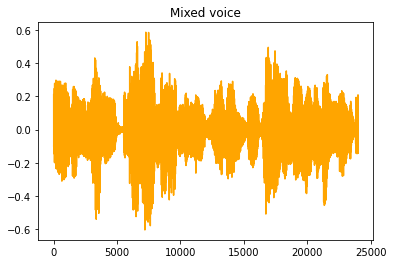

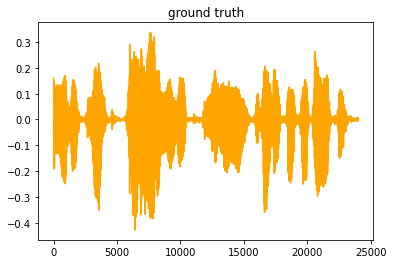

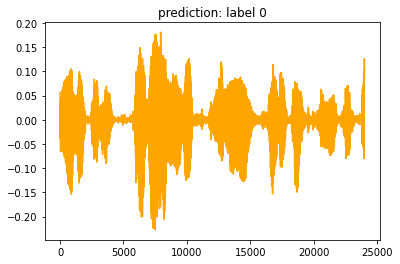

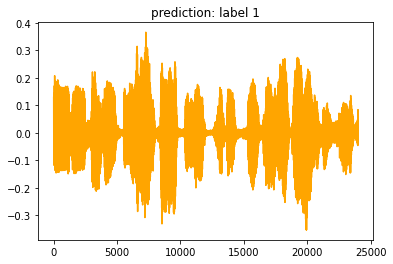

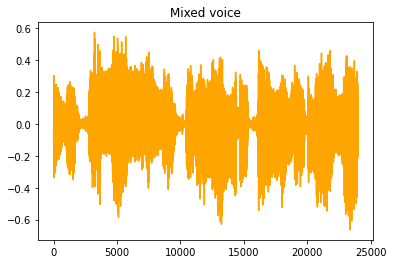

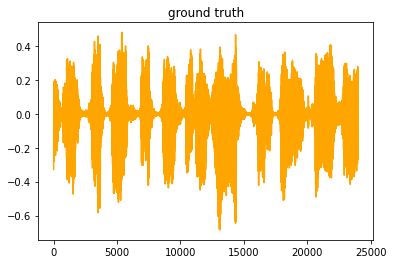

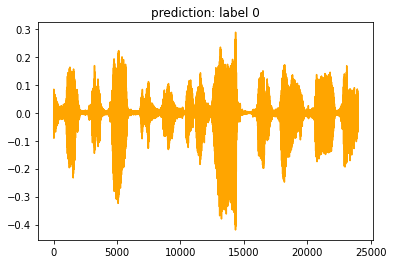

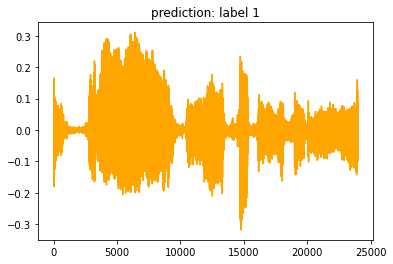

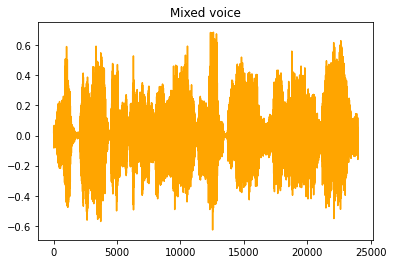

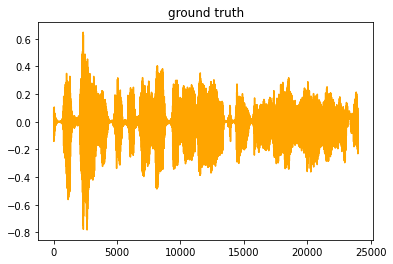

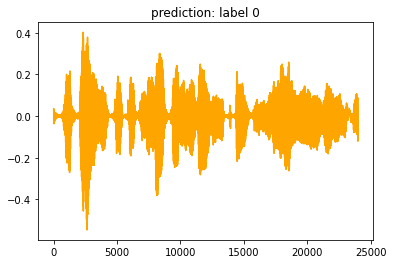

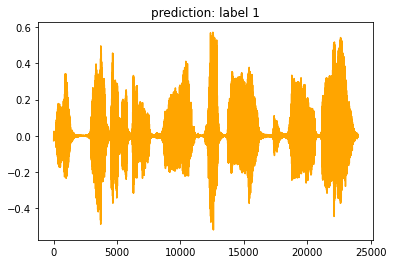

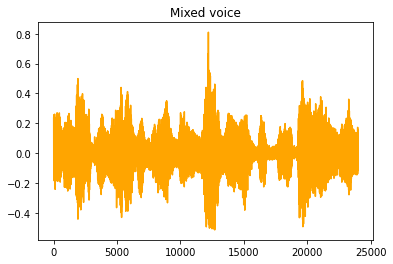

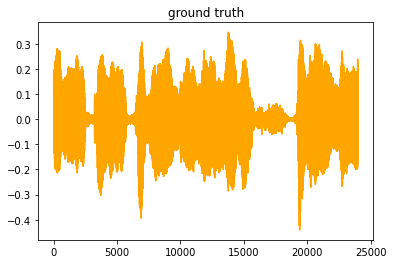

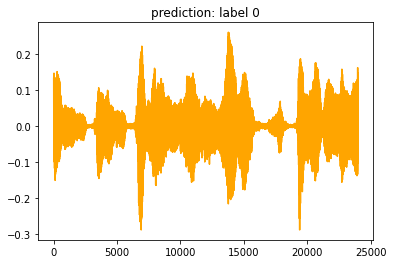

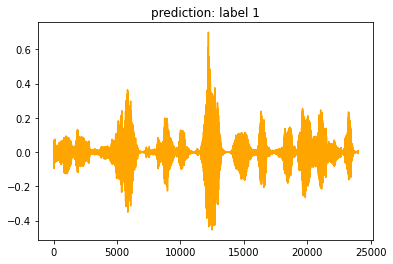

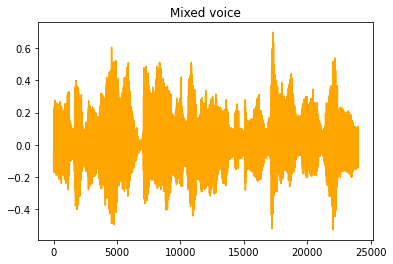

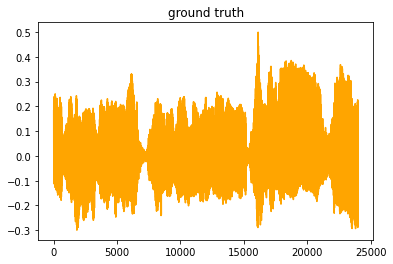

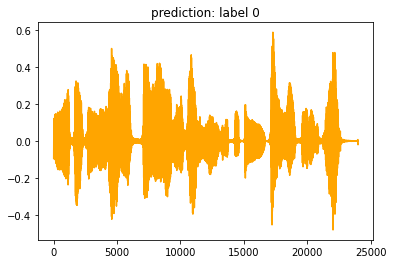

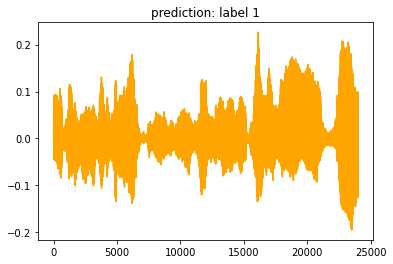

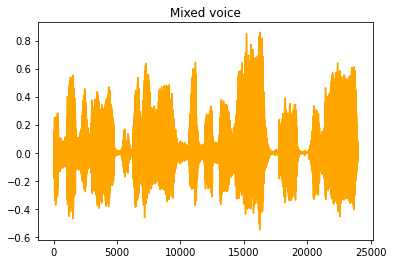

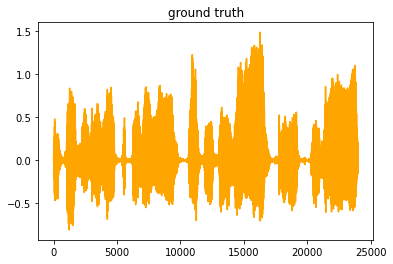

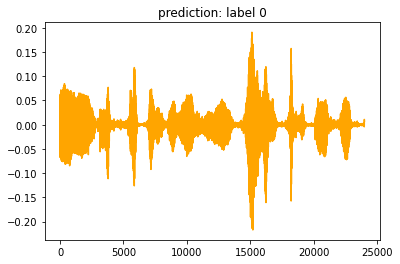

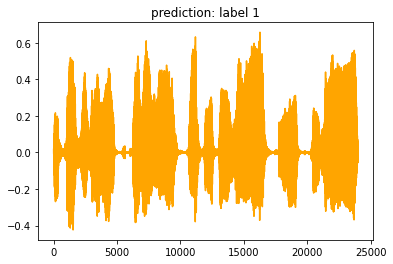

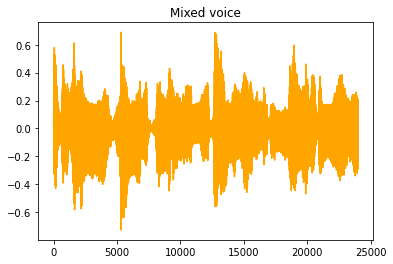

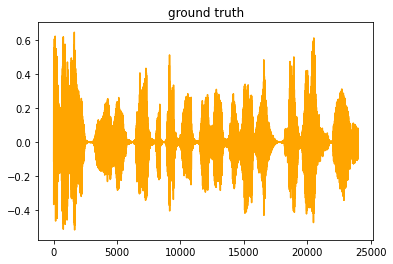

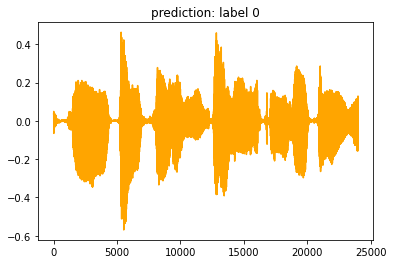

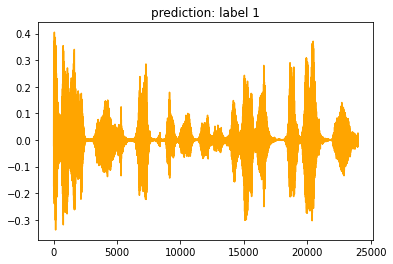

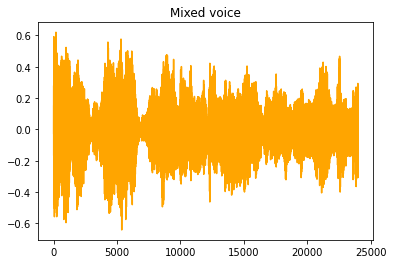

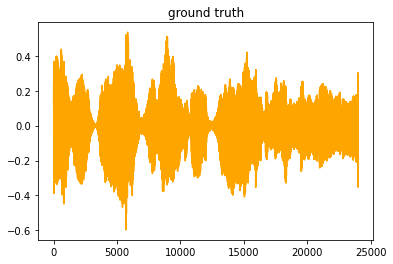

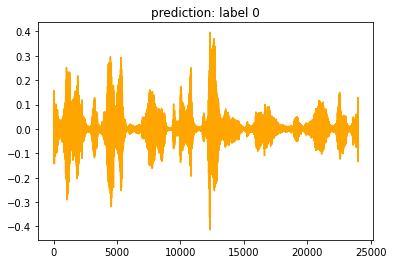

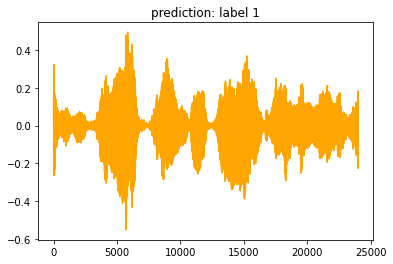

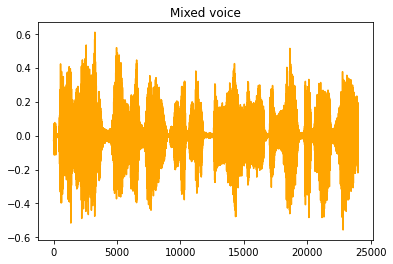

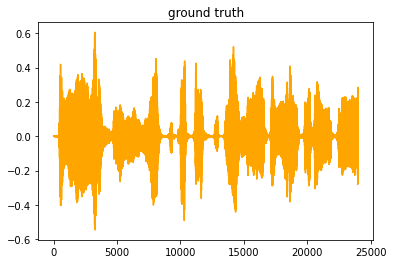

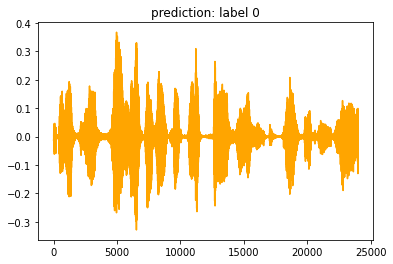

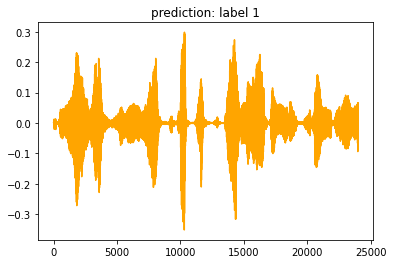

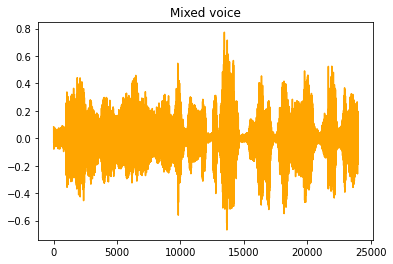

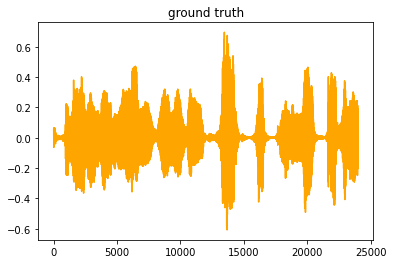

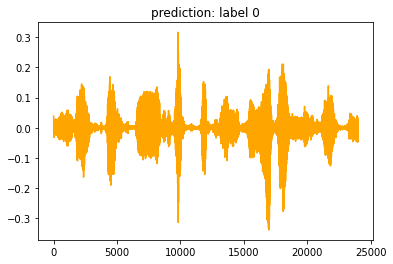

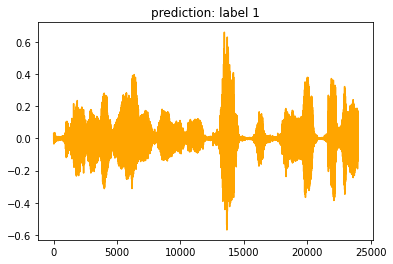

In [35]:
label_0_embeddings = np.expand_dims(embedding_matrix[0, :], axis=0)
label_1_embeddings = np.expand_dims(embedding_matrix[1, :], axis=0)

for i in range(20, 30):
  label_0_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_0_embeddings, axis=0)])
  label_1_res = model.predict([np.expand_dims(X_test[i], axis=0), np.expand_dims(label_1_embeddings, axis=0)])

  reconstruct_wav(X_test[i], test_phase[i], "Mixed voice")
  reconstruct_wav(y_test[i], test_phase[i], "ground truth")
  reconstruct_wav(label_0_res[0], test_phase[i], "prediction: label 0")
  reconstruct_wav(label_1_res[0], test_phase[i], "prediction: label 1")

# Try to test on real data

In [36]:
!gdown https://drive.google.com/uc?id=1pyq-4MRnSMrtb9FxL-pzuzACQhm28erC

Downloading...
From: https://drive.google.com/uc?id=1pyq-4MRnSMrtb9FxL-pzuzACQhm28erC
To: /content/bgm_free_audio.wav
57.6MB [00:00, 219MB/s]


In [37]:
!gdown https://drive.google.com/uc?id=1Ptnq7oNlGFbghEjYFKml0z4ae_T44Mo6

Downloading...
From: https://drive.google.com/uc?id=1Ptnq7oNlGFbghEjYFKml0z4ae_T44Mo6
To: /content/bgm_free_audio.npy
115MB [00:00, 173MB/s]


In [0]:
'load data'
# data, samplerate = sf.read('bgm_free_audio.wav')
data = load_data_array_from_npy('bgm_free_audio.npy')
# data = load_data_array_from_npy(f"gdrive/My Drive/VTB_model/new_audio_apex.npy")
'Here is the pipline'
skip_length = 8000 * 94
data = data[skip_length:]

In [0]:
def data_normalization(data, ratio = 1.1):
  norm = np.max(np.abs(data)) * ratio
  # print(norm)
  # pdb.set_trace()
  data /= norm
  return data

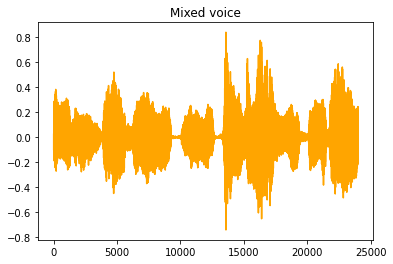

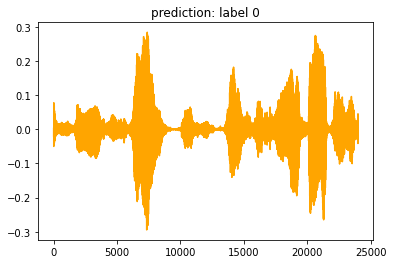

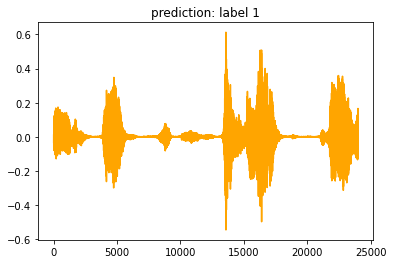

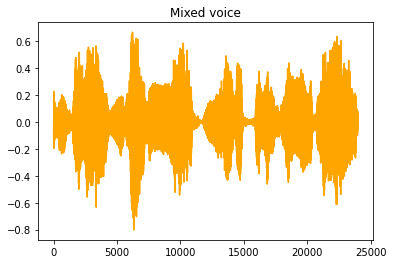

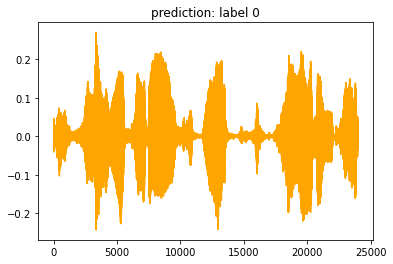

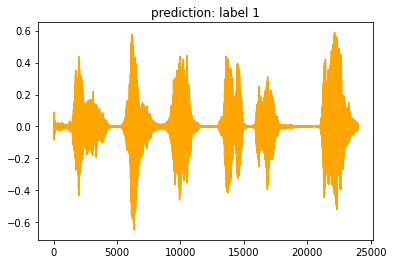

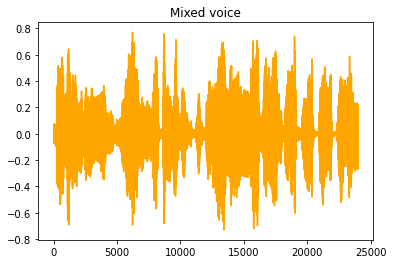

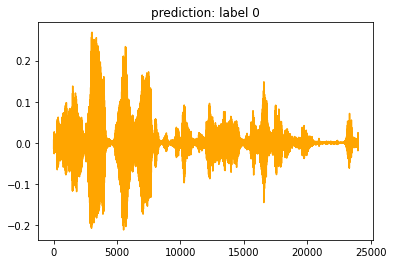

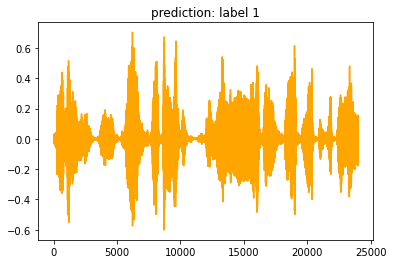

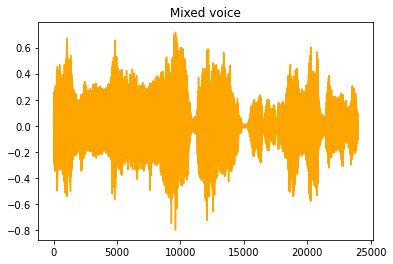

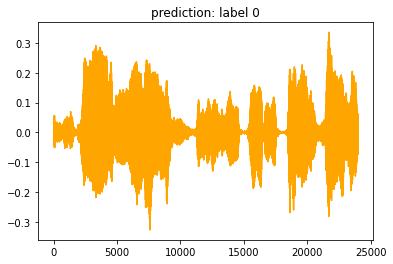

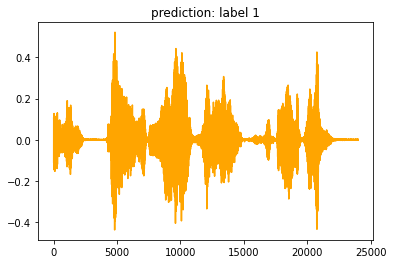

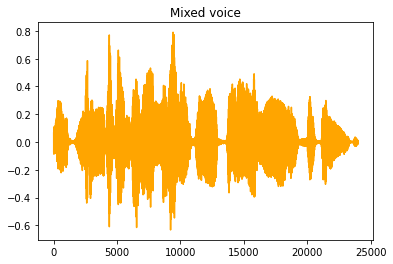

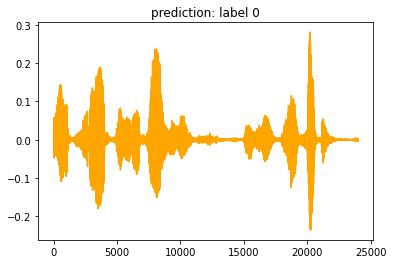

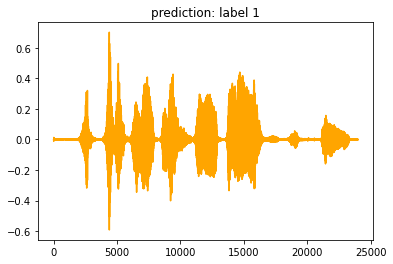

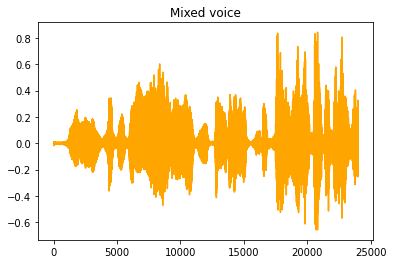

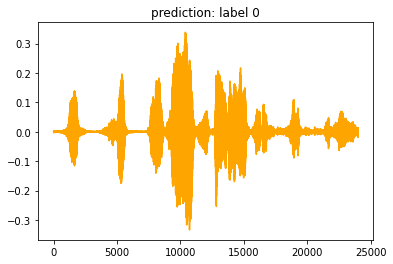

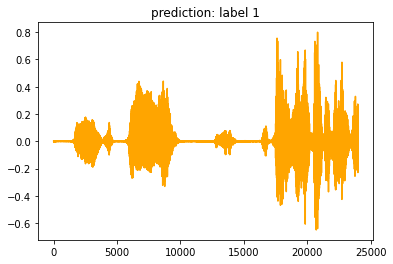

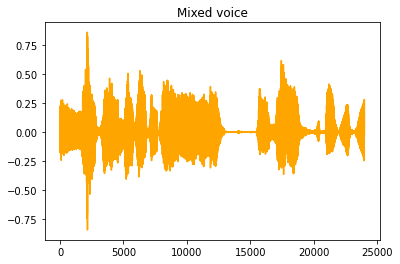

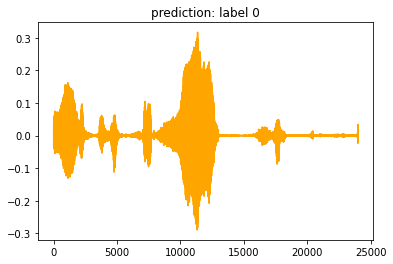

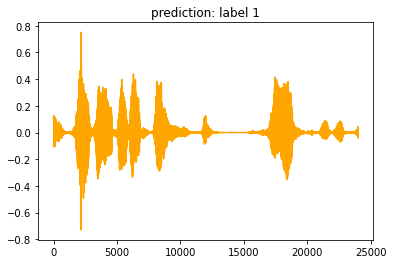

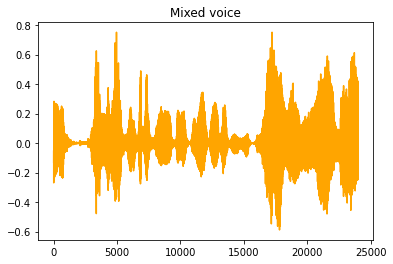

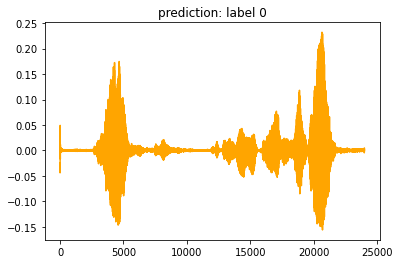

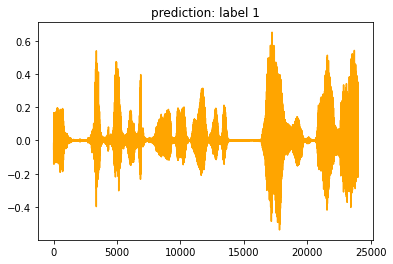

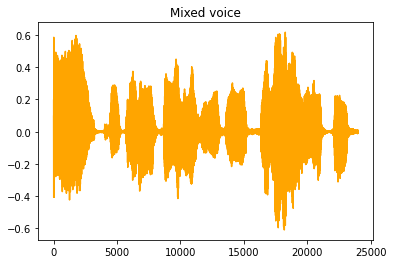

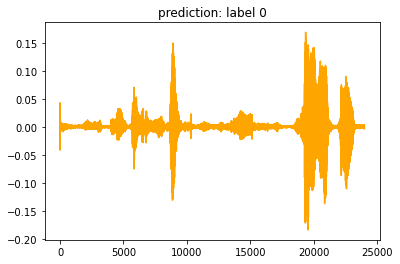

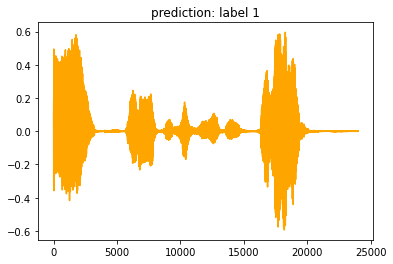

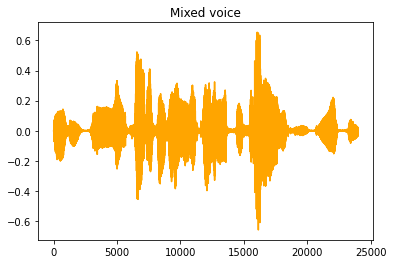

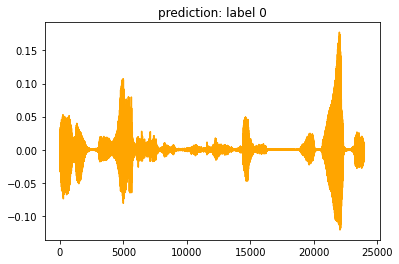

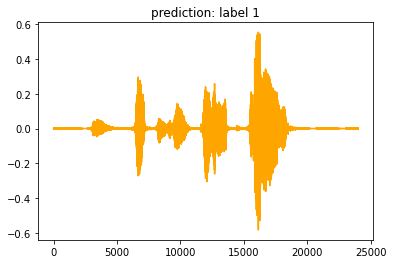

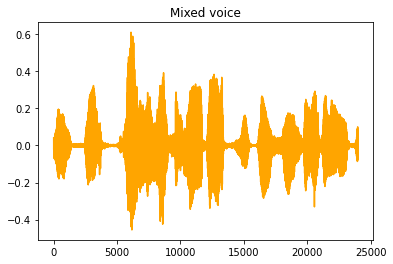

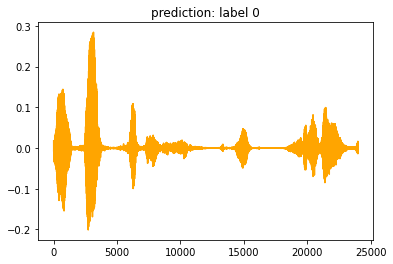

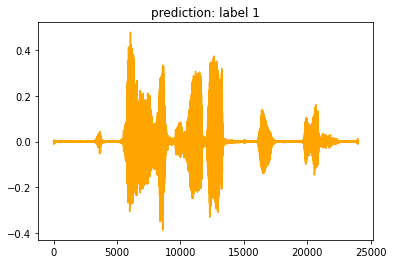

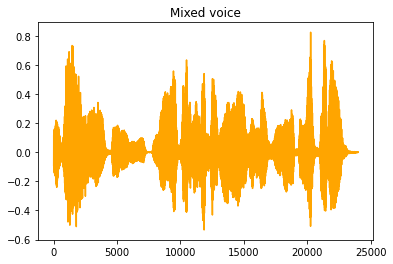

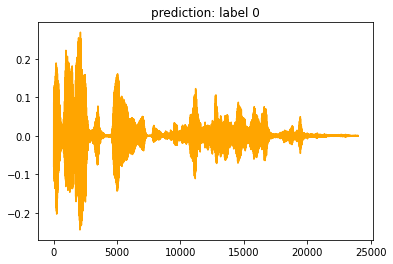

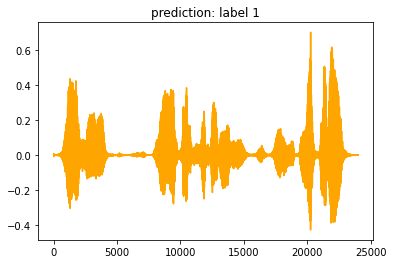

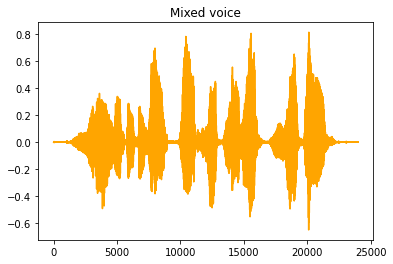

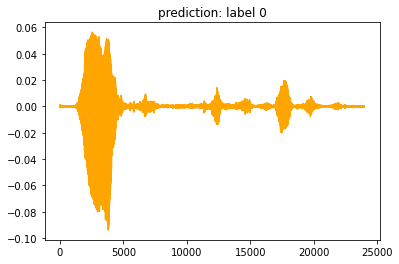

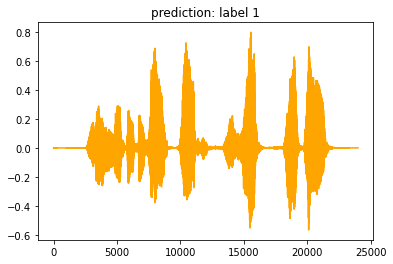

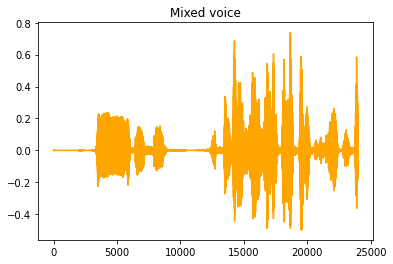

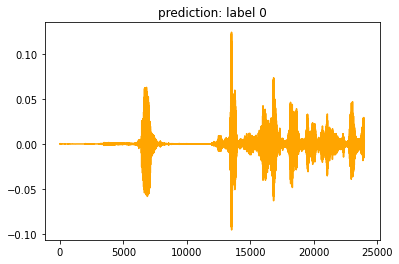

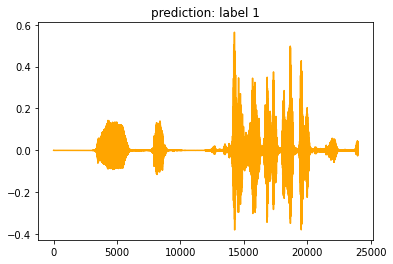

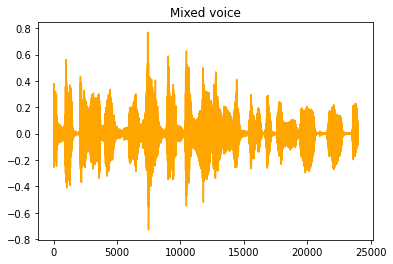

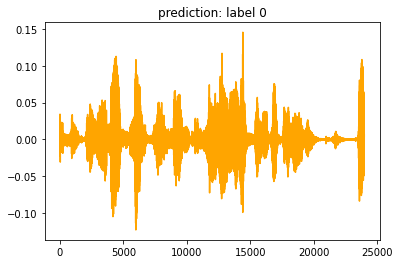

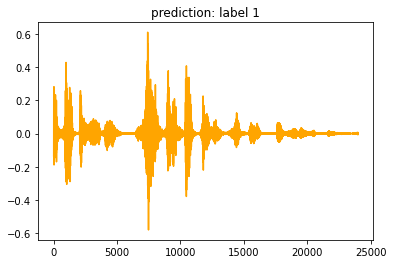

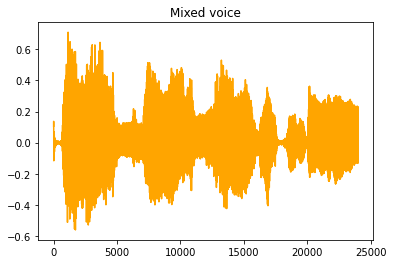

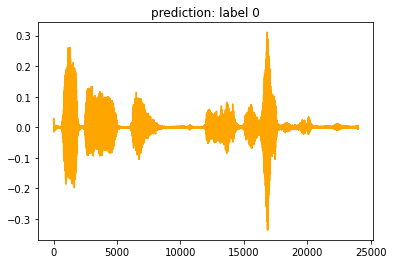

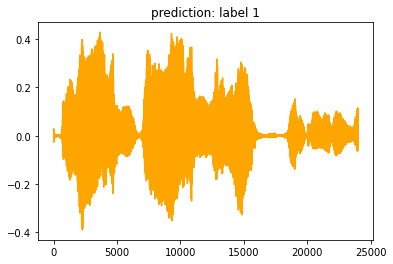

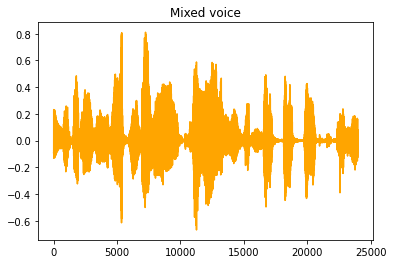

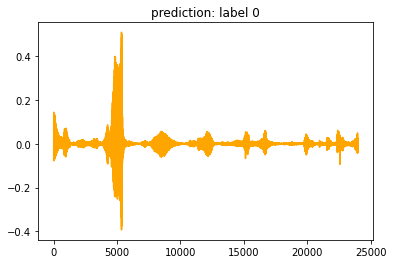

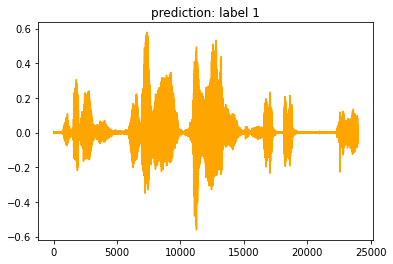

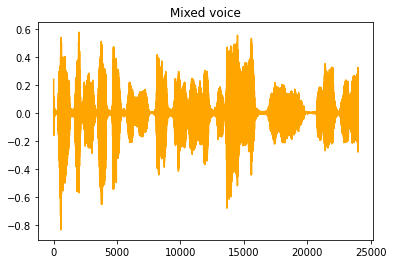

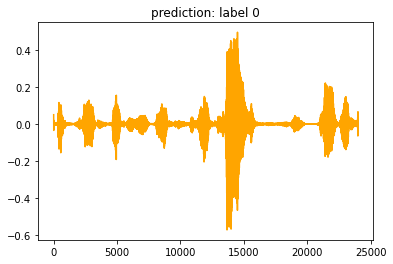

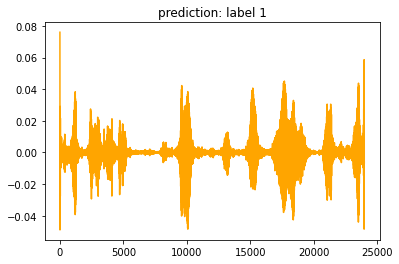

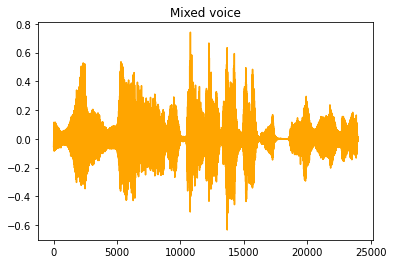

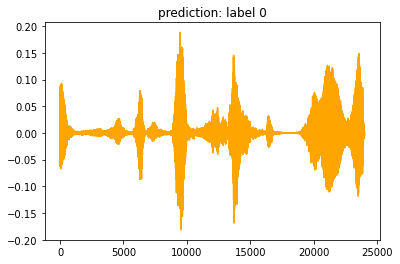

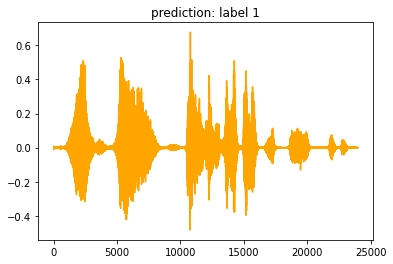

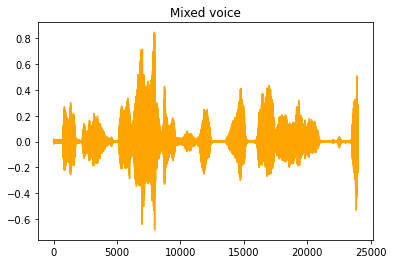

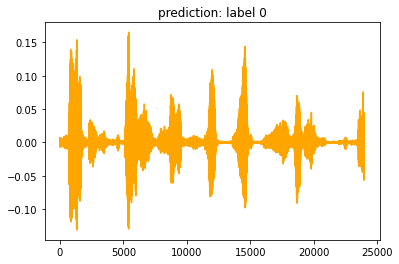

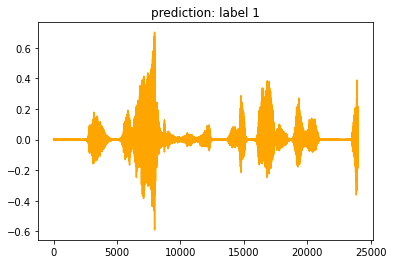

In [40]:
samplerate = 8000 * 3
total_second_number = int(len(data)//samplerate)
'iterate over the data'
splitted_res = []
for i in range(20):
  start_point = i * samplerate
  end_point = (i + 1) * samplerate
  strided_data = data[start_point:end_point]
  assert len(strided_data) == samplerate
  
  strided_data = data_normalization(strided_data, ratio=1.1)
  mixed_mag, mixed_phase = audio.wav2spec(strided_data)
  
  label_0_res = model.predict([np.expand_dims(mixed_mag, axis=0), np.expand_dims(label_0_embeddings, axis=0)])
  label_1_res = model.predict([np.expand_dims(mixed_mag, axis=0), np.expand_dims(label_1_embeddings, axis=0)])

  reconstruct_wav(mixed_mag, mixed_phase, "Mixed voice")
  reconstruct_wav(label_0_res[0], mixed_phase, f"prediction: label 0")
  reconstruct_wav(label_1_res[0], mixed_phase, f"prediction: label 1")
  # 'normalize the data'
  # if i > 20:
  #   break